## Train GPT on gym

Train a GPT model on a dedicated addition dataset to see if a Transformer can learn to add.

In [90]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [91]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [92]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [93]:
from torch.utils.data import Dataset
import sys
sys.path.append('../DRQN_pt')
import gym, envs


class GymDataset(Dataset):
    """
    Returns addition problems of up to some number of digits in the inputs. Recall
    that all GPT cares about are sequences of integers, and completing them according to
    patterns in the data. Therefore, we have to somehow encode addition problems
    as a sequence of integers.
    
    The sum of two n-digit numbers gives a third up to (n+1)-digit number. So our
    encoding will simply be the n-digit first number, n-digit second number, 
    and (n+1)-digit result, all simply concatenated together. Because each addition
    problem is so structured, there is no need to bother the model with encoding
    +, =, or other tokens. Each possible sequence has the same length, and simply
    contains the raw digits of the addition problem.
    
    As a few examples, the 2-digit problems:
    - 85 + 50 = 135 becomes the sequence [8, 5, 5, 0, 1, 3, 5]
    - 6 + 39 = 45 becomes the sequence [0, 6, 3, 9, 0, 4, 5]
    etc.
    
    We will also only train GPT on the final (n+1)-digits because the first
    two n-digits are always assumed to be given. So when we give GPT an exam later,
    we will e.g. feed it the sequence [0, 6, 3, 9], which encodes that we'd like
    to add 6 + 39, and hope that the model completes the integer sequence with [0, 4, 5]
    in 3 sequential steps.
    
    fun exercise: does it help if the result is asked to be produced in reverse order?
    """

    def __init__(self, split: str, env_name: str ="DiscreteGridworld-v0"):
        self.env = gym.make(env_name)
        self.split = split # train/test
        self.vocab_size = 12 # 12 possible... -1 through 10
        # TODO: should be env.action_space.shape[0] as well instead of 1
        self.block_size = self.env.observation_space.shape[0] * 5 + 5 + 1
        
        # split up all addition problems into either training data or test data
        # Let's start with 50k samples
        # num = (10**self.ndigit)**2 # total number of possible combinations
        # r = np.random.RandomState(1337) # make deterministic
        # perm = r.permutation(num)
        # num_test = min(int(num*0.2), 1000) # 20% of the whole dataset, or only up to 1000
        # self.ixes = perm[:num_test] if split == 'test' else perm[num_test:]

    def __len__(self):
        #return self.ixes.size
        return 50_000

    def __getitem__(self, idx):
        obs = self.env.reset()
        history = []
        for _ in range(5):
            history.append(torch.tensor(obs.copy(), dtype=torch.long))
            action = env.action_space.sample()
            history.append(torch.tensor([action], dtype=torch.long))
            obs, _, _, info = env.step(action)
        history.append(torch.tensor(info['state'].copy(), dtype=torch.long))
        h = torch.cat(([hist for hist in history]))
        x = h[:-1]
        y = h.clone()[1:]
        y[:-2] = -100
        return x, y

        obs = torch.tensor(self.env.reset(), dtype=torch.long)
        action = self.env.action_space.sample()
        next_obs, _, _, _ = self.env.step(action)
        x = torch.cat((obs, torch.tensor([action, next_obs[0]], dtype=torch.long)))
        y = torch.cat((torch.tensor([-100, -100], dtype=torch.long), torch.tensor(next_obs, dtype=torch.long)))
        return x, y



In [94]:
train_dataset = GymDataset(split='train', env_name='DiscreteHorseshoe-v0')
test_dataset = GymDataset(split='test', env_name='DiscreteHorseshoe-v0')

In [6]:
env = gym.make('DiscreteFrame-v0')

In [7]:
env.reset()

array([8, 5])

In [8]:
env.step(2)

(array([11, 11]), -1.0, False, {'state': array([7, 5])})

In [9]:
#env.render()

In [95]:
train_dataset[190] # sample a training instance just to see what one raw example looks like

(tensor([ 9,  4,  0,  8,  6,  0,  8,  7,  2, 11, 11,  3,  8,  7,  3,  9]),
 tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100,    9,    7]))

In [96]:
from mingpt.model import GPT, GPTConfig, GPT1Config

# initialize a baby GPT model
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, 
                  n_layer=2, n_head=4, n_embd=128)
model = GPT(mconf)

01/04/2022 17:19:58 - INFO - mingpt.model -   number of parameters: 4.019200e+05


In [97]:
from mingpt.trainer import Trainer, TrainerConfig

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=20, batch_size=512, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=1024, final_tokens=50*len(train_dataset)*(16),
                      ckpt_path='horseshoe_ckpt.pt', num_workers=4)
trainer = Trainer(model, train_dataset, test_dataset, tconf)
trainer.train()

epoch 1 iter 97: train loss 0.60269. lr 5.999909e-04: 100%|██████████| 98/98 [00:05<00:00, 16.45it/s]
01/04/2022 17:20:10 - INFO - mingpt.trainer -   test loss: 0.561257
01/04/2022 17:20:10 - INFO - mingpt.trainer -   saving horseshoe_ckpt.pt
epoch 2 iter 97: train loss 0.41162. lr 5.999634e-04: 100%|██████████| 98/98 [00:06<00:00, 15.83it/s]
01/04/2022 17:20:23 - INFO - mingpt.trainer -   test loss: 0.332994
01/04/2022 17:20:23 - INFO - mingpt.trainer -   saving horseshoe_ckpt.pt
epoch 3 iter 97: train loss 0.37379. lr 5.999173e-04: 100%|██████████| 98/98 [00:05<00:00, 16.79it/s]
01/04/2022 17:20:34 - INFO - mingpt.trainer -   test loss: 0.296064
01/04/2022 17:20:34 - INFO - mingpt.trainer -   saving horseshoe_ckpt.pt
epoch 4 iter 97: train loss 0.34978. lr 5.998527e-04: 100%|██████████| 98/98 [00:05<00:00, 16.38it/s]
01/04/2022 17:20:46 - INFO - mingpt.trainer -   test loss: 0.282192
01/04/2022 17:20:46 - INFO - mingpt.trainer -   saving horseshoe_ckpt.pt
epoch 5 iter 97: train loss 

In [13]:
checkpoint = torch.load('gym_ckpt.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [129]:
from mingpt.utils import sample
history = np.array([5, 5, 1, 5, 4, 1, 11, 11, 3, 11, 11, 3, 11, 11, 0])
sample(model, torch.tensor(history, dtype=torch.long, device=trainer.device)[None, ...], 1)

tensor([[ 5,  5,  1,  5,  4,  1, 11, 11,  3, 11, 11,  3, 11, 11,  0,  7]],
       device='cuda:0')

In [123]:
model.blocks[0].outputs['attention'].squeeze().T.cpu().numpy().sum(axis=0)

array([ 1.2270921 ,  1.1932425 ,  0.17198586,  0.34915292, -0.84308946,
        0.92391276,  0.413939  , -0.03974581,  1.4339856 ,  0.88868093,
        0.8276882 ,  2.9388783 ,  0.71869373,  0.7343292 ,  0.1599412 ,
        2.3281765 ], dtype=float32)

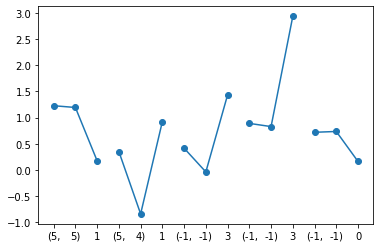

In [131]:
#fig, axs = plt.subplots(nrows=2, sharex=True)
seq_len = 15
fig, ax = plt.subplots()
for i in range(1):
    attn = model.blocks[i].outputs['attention'].squeeze().T.cpu().numpy().sum(axis=0)
    ax.scatter(range(seq_len), attn)
    for j in range(0, len(attn), 3):
        if len(attn[j:j+3]) < 3:
            continue
        ax.plot(range(j, j+3), attn[j:j+3], c='tab:blue')
#ax.plot(range(3, 6), attn[3:6], c='tab:blue')
ax.set_xticks(range(seq_len))
ax.set_xticklabels(['(5,', '5)', '1', '(5,', '4)', '1', '(-1,', '-1)', '3', '(-1,', '-1)', '3', '(-1,', '-1)', '0'])
plt.show()

In [41]:
model.blocks[0].outputs['mlp'].squeeze().T.cpu().numpy().sum(axis=0)

array([ 0.24354684,  0.24462736,  0.22080696,  1.5651207 ,  1.9733088 ,
        1.8581808 ,  0.8155133 , -0.48296237,  2.5775948 ,  3.0177174 ,
        2.9929147 , -0.09368896,  3.0635016 ,  3.1225886 ,  1.9389458 ,
        0.85987616], dtype=float32)

In [38]:
model.blocks[1].outputs['attention'].squeeze().T.cpu().numpy().sum(axis=0)

array([ 1.959651  ,  1.8339162 ,  2.0441227 ,  3.0658896 ,  3.3538513 ,
        1.7241983 ,  2.6646807 ,  1.6031058 , -2.5267706 ,  0.8638041 ,
        1.0844204 , -1.8708265 ,  0.7843232 ,  1.151099  , -0.08955133,
       -6.7240005 ], dtype=float32)

In [42]:
model.blocks[1].outputs['mlp'].squeeze().T.cpu().numpy().sum(axis=0)

array([-2.3619685 , -2.5210905 , -2.75309   , -0.5954666 ,  0.3862114 ,
        0.52429676, -1.2816153 ,  0.40455627, -6.024131  , -8.104212  ,
       -8.785734  , -1.4268901 , -8.68998   , -9.225517  , -5.395953  ,
       -4.588853  ], dtype=float32)

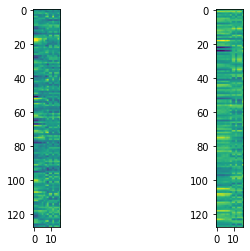

In [33]:
figs, axs = plt.subplots(1, 2)
axs[0].imshow(model.blocks[0].outputs['attention'].squeeze().T.cpu().numpy())
axs[1].imshow(model.blocks[1].outputs['attention'].squeeze().T.cpu().numpy())

In [18]:
env = gym.make('DiscreteTargets-v0')
def test_model(test_len=500):
    num_correct = 0
    for _ in range(test_len):
        obs = env.reset()
        history = []
        for i in range(5):
            history.append(torch.tensor(obs.copy(), dtype=torch.long))
            action = env.action_space.sample()
            obs, _, _, info = env.step(action)
            history.append(torch.tensor([action], dtype=torch.long))
        result = sample(model, torch.cat(([hist for hist in history])).to(trainer.device)[None, ...], 2)
        pred_state = result.squeeze()[-2:].cpu().numpy()
        if np.array_equal(info['state'], pred_state):
            num_correct += 1
            #print(f"Predicted {pred_state} and was {info['state']}. Full sequence: {result}")
        else:
            #pass
            print(f"Predicted {pred_state} but was {info['state']}. Full sequence: {result}")
    print(f"Final score: {(100*num_correct/test_len):.2f}%!")
test_model()

Predicted [5 2] but was [6 7]. Full sequence: tensor([[11, 11,  1, 11, 11,  2, 11, 11,  1, 11, 11,  0, 11, 11,  2,  5,  2]],
       device='cuda:0')
Predicted [1 5] but was [6 5]. Full sequence: tensor([[11, 11,  3, 11, 11,  2, 11, 11,  1, 11, 11,  1, 11, 11,  1,  1,  5]],
       device='cuda:0')
Predicted [1 1] but was [7 2]. Full sequence: tensor([[ 9,  3,  2, 11, 11,  2, 11, 11,  1, 11, 11,  0, 11, 11,  1,  1,  1]],
       device='cuda:0')
Predicted [0 2] but was [5 7]. Full sequence: tensor([[11, 11,  0, 11, 11,  3, 11, 11,  1, 11, 11,  2, 11, 11,  2,  0,  2]],
       device='cuda:0')
Predicted [1 3] but was [1 8]. Full sequence: tensor([[ 3,  5,  0, 11, 11,  0, 11, 11,  2, 11, 11,  2, 11, 11,  0,  1,  3]],
       device='cuda:0')
Predicted [3 7] but was [7 7]. Full sequence: tensor([[ 6,  9,  1, 11, 11,  1, 11, 11,  1, 11, 11,  3, 11, 11,  0,  3,  7]],
       device='cuda:0')
Predicted [0 2] but was [3 4]. Full sequence: tensor([[ 4,  6,  1, 11, 11,  3, 11, 11,  1, 11, 11,  2, 11,

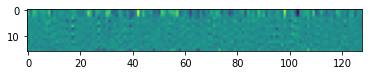

In [26]:
import matplotlib.pyplot as plt
embeds = model.pos_emb.data[0].cpu().numpy()
fig, ax = plt.subplots()
im = ax.imshow(embeds)
plt.show()

In [17]:
env = gym.make('DiscreteHorseshoe-v0')

In [18]:
env.step(0)

AssertionError: Cannot call env.step() before calling reset()

In [ ]:
x = torch.tensor([1, 2, 0], dtype=torch.long, device=trainer.device)
x.shape

torch.Size([3])

In [ ]:
# now let's give the trained model an addition exam
from torch.utils.data.dataloader import DataLoader
from mingpt.utils import sample

def give_exam(dataset, batch_size=32, max_batches=-1):
    
    results = []
    loader = DataLoader(dataset, batch_size=batch_size)
    for b, (x, y) in enumerate(loader):
        x = x.to(trainer.device)
        d1d2 = x[:, :ndigit*2]
        d1d2d3 = sample(model, d1d2, ndigit+1)
        d3 = d1d2d3[:, -(ndigit+1):]
        factors = torch.tensor([[10**i for i in range(ndigit+1)][::-1]]).to(trainer.device)
        # decode the integers from individual digits
        d1i = (d1d2[:,:ndigit] * factors[:,1:]).sum(1)
        d2i = (d1d2[:,ndigit:ndigit*2] * factors[:,1:]).sum(1)
        d3i_pred = (d3 * factors).sum(1)
        d3i_gt = d1i + d2i
        correct = (d3i_pred == d3i_gt).cpu() # Software 1.0 vs. Software 2.0 fight RIGHT on this line, lol
        for i in range(x.size(0)):
            results.append(int(correct[i]))
            judge = 'YEP!!!' if correct[i] else 'NOPE'
            if not correct[i]:
                print("GPT claims that %03d + %03d = %03d (gt is %03d; %s)" 
                      % (d1i[i], d2i[i], d3i_pred[i], d3i_gt[i], judge))
        
        if max_batches >= 0 and b+1 >= max_batches:
            break

    print("final score: %d/%d = %.2f%% correct" % (np.sum(results), len(results), 100*np.mean(results)))

In [ ]:
# training set: how well did we memorize?
give_exam(train_dataset, batch_size=1024, max_batches=10)

In [ ]:
# test set: how well did we generalize?
give_exam(test_dataset, batch_size=1024, max_batches=-1)

In [ ]:
# well that's amusing... our model learned everything except 55 + 45